In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D
from scipy.signal import butter, filtfilt
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from scipy.signal import sosfilt
plt.rcParams['figure.dpi'] = 150

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# LOAD THE DATA
df1_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
df2_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#4.txt.txt')
df3_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#5.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Merge ACC datasets
df_raw = pd.concat([df1_raw, df2_raw], ignore_index=True)
df_raw = pd.concat([df_raw,df3_raw],ignore_index=True)

In [4]:
# Convert timestamp from string to datetime
df_raw['datetime_txt'] = df_raw['Date'] + " " + df_raw['Time hh:mm:ss.ddd']
df_raw['datetime'] = pd.to_datetime(df_raw['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

In [5]:
# Select Columns
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

In [6]:
# Merge GPS and activity data
df_raw = pd.merge(df_raw, gps, on='datetime', how='left')

In [7]:
len(df_raw)

2261342

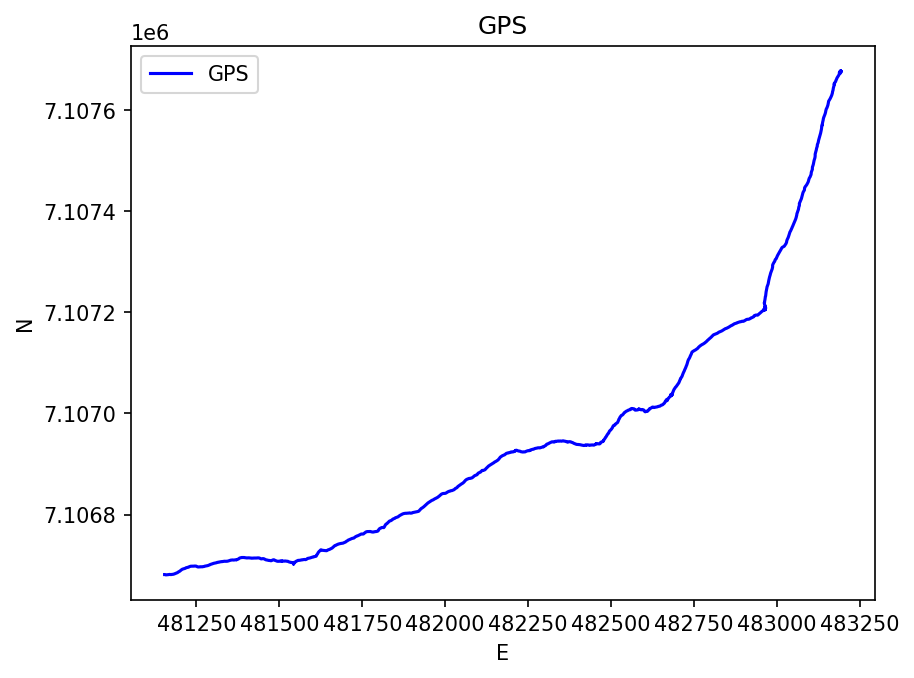

In [8]:
# PLOT GPS OVER TIME
# Calculate distance traveled during GPS track using the euclidean distance formula on each step
start_time = '2019-02-26 04:00:00'
end_time = '2019-02-26 05:30:00'

gps_pts = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)][df_raw['UTM_E'].notnull()]

x = gps_pts['UTM_E']
y = gps_pts['UTM_N']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(x, y,  color='b', label='GPS')

# Setting labels
ax.set_xlabel('E')
ax.set_ylabel('N')

# Adding a title and legend
ax.set_title('GPS')
ax.legend()

# Show plot
plt.show()

In [9]:
# Define start and end pts of each step
x0 = gps_pts['UTM_E'].iloc[:-1].values
x1 = gps_pts['UTM_E'].iloc[1:].values
y0 = gps_pts['UTM_N'].iloc[:-1].values
y1 = gps_pts['UTM_N'].iloc[1:].values

# Calculate x1-x0 and y1-y0
x_diff = x1-x0
y_diff = y1-y0

# Compute (x1-x0)^2 and (y1-y0)^2
x_diff_sqr = x_diff*x_diff
y_diff_sqr = y_diff*y_diff

# Compute (x1-x0)^2 + (y1-y0)^2
xy_diff_sqr_sum = x_diff_sqr + y_diff_sqr

# Compute ((x1-x0)^2 + (y1-y0)^2)^0.5
euclidean_distance_step = [math.sqrt(x) for x in xy_diff_sqr_sum]

# Compute total distance travel
gps_distance_traveled = sum(euclidean_distance_step)
gps_distance_traveled

2734.6013285343206

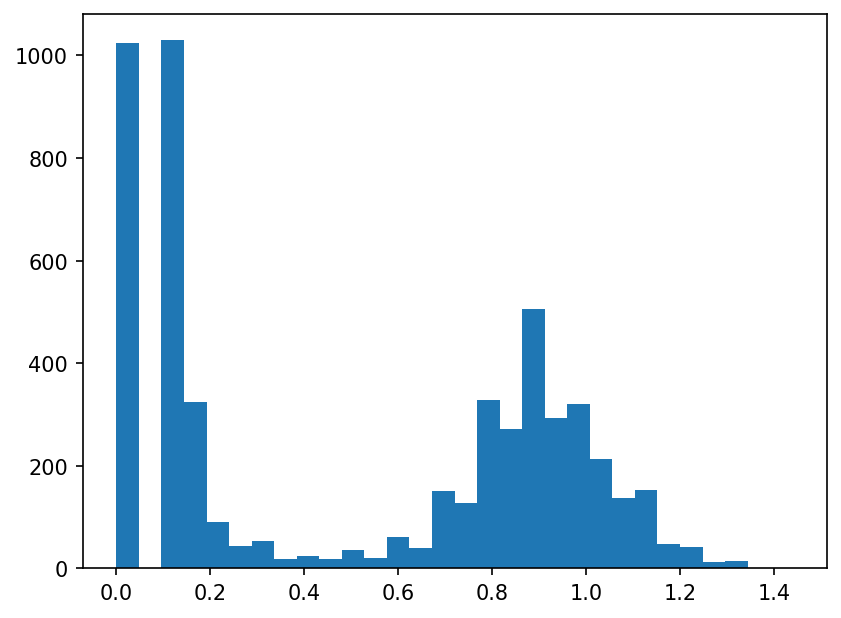

In [10]:
plt.hist(euclidean_distance_step,bins = 30)
plt.show()

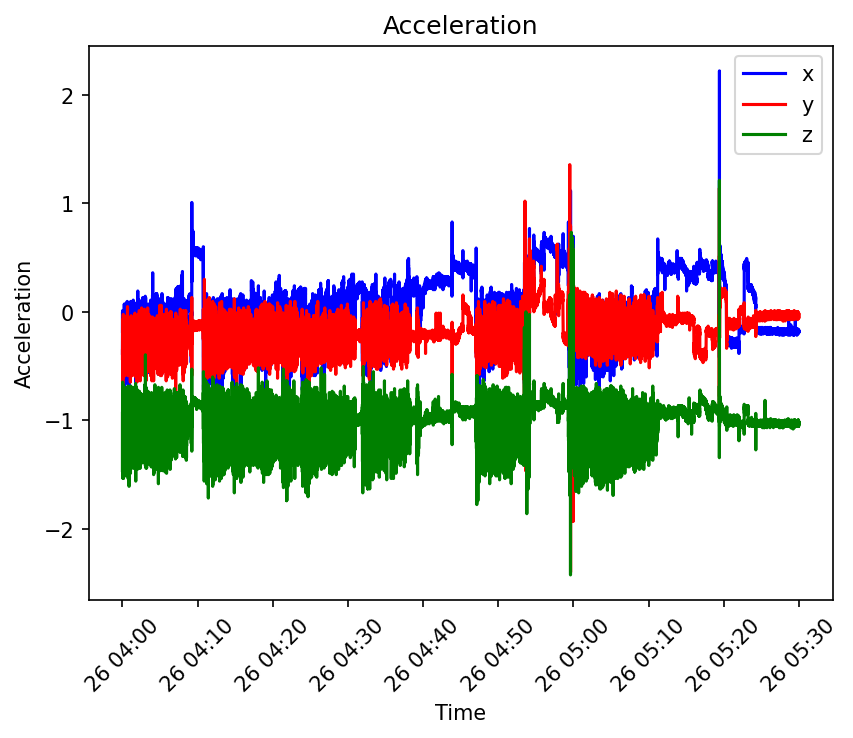

In [11]:
df = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)].reset_index()

# PLOT ACCELERATION OVER TIME
Acc_x = df['Acc_x']
Acc_y = df['Acc_y']
Acc_z = df['Acc_z']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y,  linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z,  linestyle='-', color='g', label='z')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

## 1) Remove effects of pitch and roll

Static acceleration is estimated using a 4th order zero phase low pass butterworth filter with wc = 0.1 Hz following Ladha et al. 2018 (BMC Veterinary Research). 

In [12]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.1  # Cutoff frequency in Hz
sampling_rate = 2  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [13]:
# APPLY THE FILTER TO CALCULATE STATIC ACCELERATION

df['Gx'] = filtfilt(b, a, df['Acc_x'])
df['Gy'] = filtfilt(b, a, df['Acc_y'])
df['Gz'] = filtfilt(b, a, df['Acc_z'])

# Calculate Dynamic Acceleration
df['DAx'] = df['Acc_x'] - df['Gx']
df['DAy'] = df['Acc_y'] - df['Gy']
df['DAz'] = df['Acc_z'] - df['Gz']

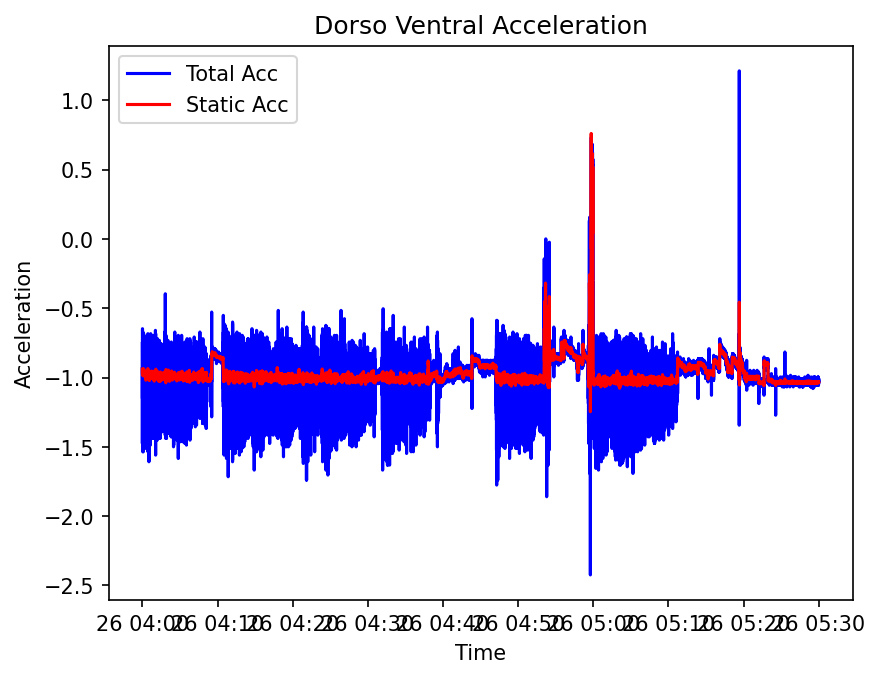

In [14]:
# PLOT STATIC ACCLERATION
Acc_z = df['Acc_z']
Gz = df['Gz']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_z,  linestyle='-', color='b', label='Total Acc')
ax.plot(dt, Gz,  linestyle='-', color='r', label='Static Acc')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Dorso Ventral Acceleration')
ax.legend()

# Show plot
plt.show()

In [15]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    #pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    pitch = math.atan2(gy,math.sqrt(gx**2 + gz**2))
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [16]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    #roll = math.atan2(gy,math.sqrt(gx**2 + gz**2))
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

In [17]:
# ROTATE DATA

# Build rotation function
def rotate_data(row):
    pitch = row['pitch']
    roll = row['roll']
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),math.sin(pitch)],
          [0,-math.sin(pitch),math.cos(pitch)]])
    Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
         [0,1,0],
         [math.sin(roll),0,math.cos(roll)]])
    Ax = row['Acc_x']
    Ay = row['Acc_y']
    Az = row['Acc_z']
    A = np.array([[Ax],[Ay],[Az]])
    RA = Ry @ Rx @ A
    row['RAx'] = RA[0]
    row['RAy'] = RA[1]
    row['RAz'] = RA[2]
    return row

# Initialize columns
df['RAx'] = -999
df['RAy'] = -999
df['RAz'] = -999

# Rotate data
df = df.apply(rotate_data,axis=1)

## Identify movement periods using magnitude threshold

In [50]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.2  # Cutoff frequency in Hz
sampling_rate = 1.0  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [51]:
# APPLY THE FILTER TO ROTATED DATA
df['FRAx'] = filtfilt(b, a, df['RAx'])
df['FRAy'] = filtfilt(b, a, df['RAy'])
df['FRAz'] = filtfilt(b, a, df['RAz'])

In [80]:
# Compute magnitude of acceleration vector
df['FRAx'] = pd.to_numeric(df['FRAx'], errors='coerce')
df['FRAy'] = pd.to_numeric(df['FRAy'], errors='coerce')
df['FRAz'] = pd.to_numeric(df['FRAz'], errors='coerce')
df['magnitude'] = np.sqrt(df['FRAx']**2 + df['FRAy']**2 + df['FRAz']**2)

# Define a threshold for classifying activity based on standard deviation
sd_threshold = 0.01 # standard deviation

# Calculate standard deviation of magnitude of acceleration using a rolling window
window_size = 50 # 5 Seconds
df['mag_sd'] = df['magnitude'].rolling(window=window_size).std()



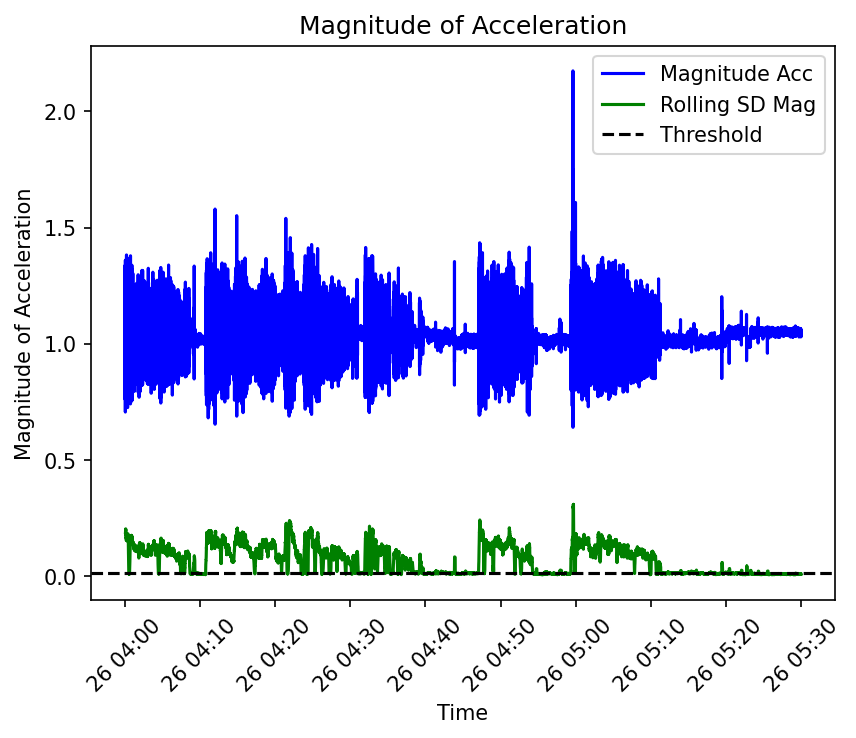

In [81]:
# Plot magnitude vs time
mag = df['magnitude']
dt = df['datetime']
mag_std = df['mag_sd']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, mag, linestyle='-', color='b', label='Magnitude Acc')
ax.plot(dt,mag_std,linestyle="-", color = "g", label = "Rolling SD Mag")
plt.axhline(y=sd_threshold, color='black', linestyle='--', label='Threshold')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude of Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Magnitude of Acceleration')
ax.legend()

# Show plot
plt.show()

In [91]:
# Classify activity based on SD of Acc magnitude

def classify_activity(row):
    global sd_threshold
    if row['mag_sd'] > sd_threshold:
        return 1 #active
    else:
        return 0 #resting

# Apply the function to populate column B
df['active'] = df.apply(classify_activity, axis=1)


In [95]:
# Split activity periods into groups

# Initialize group column
df['activity_group'] = -999

# Initialize previous activity status
prev_activity = 0
group = 0

# Define activity groups
for i in range(0,len(df)):
    current_activity = df.loc[i,'active']
    if current_activity == 1:
        if current_activity == prev_activity:
            df.loc[i,'activity_group'] = group
        else:
            group += 1
            df.loc[i,'activity_group'] = group
    prev_activity = current_activity

In [96]:
active_periods = df[df['active']==1].reset_index()

## Identify candidate steps using dynamic threshold on filtered DV axis

In [22]:
# DERIVE ZERO THRESHOLD USIng 20s WINDOWS

# Set the timestamp as the index
df.set_index('datetime', drop = False, inplace = True) 

# Initialize zero threshold column
df['thresh_z'] = -999

# Initialize falling flank column
df['falling_edges'] = False

for window_start in df.resample('20S').groups:
    
    window_data = df.loc[window_start:window_start + pd.Timedelta(seconds=20)]

    # Identify mean of max peak and min nadir in each window for acc in z axis
    signal = window_data['FRAz'].values
    max_z = signal.max()
    min_z = signal.min()
    thresh = (max_z + min_z)/2
    window_data['thresh_z'] = thresh

    # Identify falling flanks that cross the zero threshold 
    
    falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
    window_data['falling_edges'].iloc[1:] = falling_edges

    df.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data
    

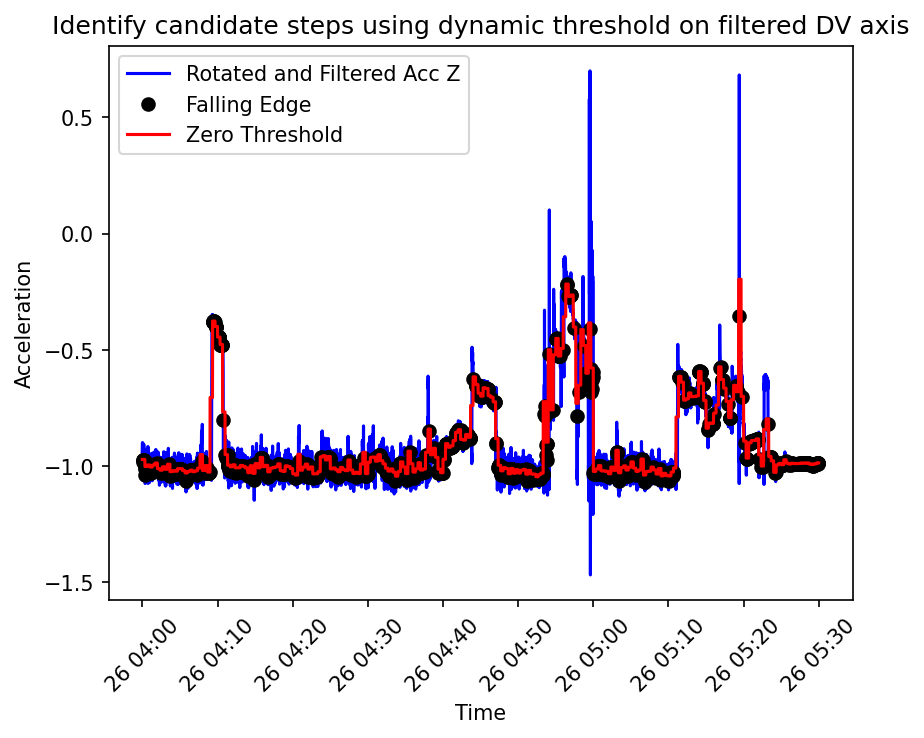

In [23]:
# PLOT ZERO THRESHOLD
FRAz = df['FRAz']
thresh_z = df['thresh_z']
dt = df['datetime']
dt_falling_edges = df[df['falling_edges'] == True]['datetime']
falling_edges = df[df['falling_edges'] == True]['FRAz']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, FRAz, linestyle='-', color='b', label='Rotated and Filtered Acc Z')
ax.plot(dt_falling_edges, falling_edges, marker = "o",linestyle='', color='black', label='Falling Edge')
ax.plot(dt, thresh_z,  linestyle='-', color='r', label='Zero Threshold')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Identify candidate steps using dynamic threshold on filtered DV axis')
ax.legend()

# Show plot
plt.show()


## Parameterize Valid Step Frequency

In [24]:
# # Filter out false steps based on range of valid step frequencies
# def step_freq_filter(row, min_stride_freq, max_stride_freq):
#     min_period = 1 / max_stride_freq
#     max_period = 1 / min_stride_freq
#     obs_freq = row['elapsed_time']
    
#     if min_period <= obs_freq <= max_period:
#         return 1
#     else:
#         return 0

# # Estimate distance traveled
# def estimate_distance(steps, acc):
#     # Initialize distance column
#     steps['distance_traveled'] = 0
#     # Calculate distance
#     for i in range(1, len(steps) - 1):
#         # Identify the start and the end of the stride
#         t_start_of_stride = steps.iloc[i - 1]['datetime']
#         t_end_of_stride = steps.iloc[i + 1]['datetime']
        
#         # Filter for accelerometry data between the start and end of the stride
#         stride_data = acc[(acc['datetime'] >= t_start_of_stride) & (acc['datetime'] <= t_end_of_stride)]
#         acc.loc[(acc['datetime'] >= t_start_of_stride) & (acc['datetime'] <= t_end_of_stride), 'valid_step'] = 1
        
#         # Get max and min acceleration
#         max_acc = stride_data['RAz'].max()
#         min_acc = stride_data['RAz'].min()
        
#         # Estimate distance
#         h = (max_acc - min_acc) ** 0.25
#         steps.at[i, 'distance_traveled'] = h
    
#     # Estimate cumulative distance
#     cum_dist = steps['distance_traveled'].sum()
#     return cum_dist

# # Generate predicted travel distances using different valid step frequencies
# def model_predictions(params, acc_data):
#     min_stride_freq, max_stride_freq = params
    
#     # Filter dataframe for step candidates
#     step_candidates = acc_data[acc_data['falling_edges'] == True].copy()
    
#     # Compute time dif between candidates
#     step_candidates['elapsed_time'] = step_candidates['datetime'].diff().dt.total_seconds()
    
#     # Reset indices of step_candidates and df
#     acc_data['rowID'] = range(len(acc_data))
#     step_candidates['rowID'] = range(len(step_candidates))
    
#     acc_data.set_index('rowID', inplace=True)
#     step_candidates.set_index('rowID', inplace=True)
    
#     # Identify valid steps
#     step_candidates['valid_step'] = step_candidates.apply(lambda row: step_freq_filter(row, min_stride_freq, max_stride_freq), axis=1)
    
#     step_candidates = step_candidates[['valid_step', 'datetime']]
#     step_candidates = step_candidates[step_candidates['valid_step'] == 1].reset_index()
    
#     # Calculate cumulative distance traveled from valid steps
#     dist = estimate_distance(step_candidates, acc_data)
#     return dist

# # Define the cost function
# def cost_function(params, acc_data, actual):
#     prediction = model_predictions(params, acc_data)
#     dist_diff = abs(prediction - actual)
#     return dist_diff

# def objective(params):
#     return cost_function(params, acc_data, actual)

# # Example data (replace with your actual data)
# acc_data = df
# actual = gps_distance_traveled

# # Differential Evolution (a type of genetic algorithm)
# bounds = [(0.5, 1), (1.1, 2)]  # Example parameter bounds
# result = differential_evolution(objective, bounds)

# print("Optimal parameters:", result.x)
# print("Optimal value:", result.fun)

In [25]:
# VALID STEP FREQUENCIES
# Based on range of observed stride frequencies in Eland (a species of comparable body mass; stride frequency is known to scale w body mass)
min_stride_freq = 0.5
max_stride_freq = 2

In [26]:
# Filter dataframe for step candidates
step_candidates = df[df['falling_edges'] == True]

In [27]:
# Compute time between candidates
step_candidates['elapsed_time'] = step_candidates['datetime'].diff().apply(lambda x: x.total_seconds())

In [28]:
# Reset indices of step_candidates and df
df['rowID'] = range(0,len(df))
step_candidates['rowID'] = range(0,len(step_candidates))
df.set_index('rowID', inplace = True) 
step_candidates.set_index('rowID', inplace = True) 

In [29]:
# Filter out false steps based on range of valid step frequencies

def step_freq_filter(row):
    
    global min_stride_freq
    global max_stride_freq
    
    min_period = 1/max_stride_freq
    max_period = 1/min_stride_freq

    obs_freq = row['elapsed_time']

    if obs_freq >= min_period and obs_freq <= max_period:
        return 1
    else:
        return 0

# Identify valid steps
step_candidates['valid_step'] = step_candidates.apply(step_freq_filter,axis=1)
step_candidates = step_candidates[['valid_step','datetime']]
step_candidates = step_candidates[step_candidates['valid_step'] == 1].reset_index()

In [30]:
# Join step candidates back to original df
df = pd.merge(step_candidates, df,on = 'datetime', how='right')


In [31]:
step_candidates

,rowID,valid_step,datetime
0,1,1,2019-02-26 04:00:04.000
1,5,1,2019-02-26 04:00:14.170
2,6,1,2019-02-26 04:00:15.589
3,7,1,2019-02-26 04:00:16.487
4,8,1,2019-02-26 04:00:17.775
...,...,...,...
1293,2045,1,2019-02-26 05:29:48.897
1294,2046,1,2019-02-26 05:29:49.756
1295,2049,1,2019-02-26 05:29:55.175
1296,2050,1,2019-02-26 05:29:56.658


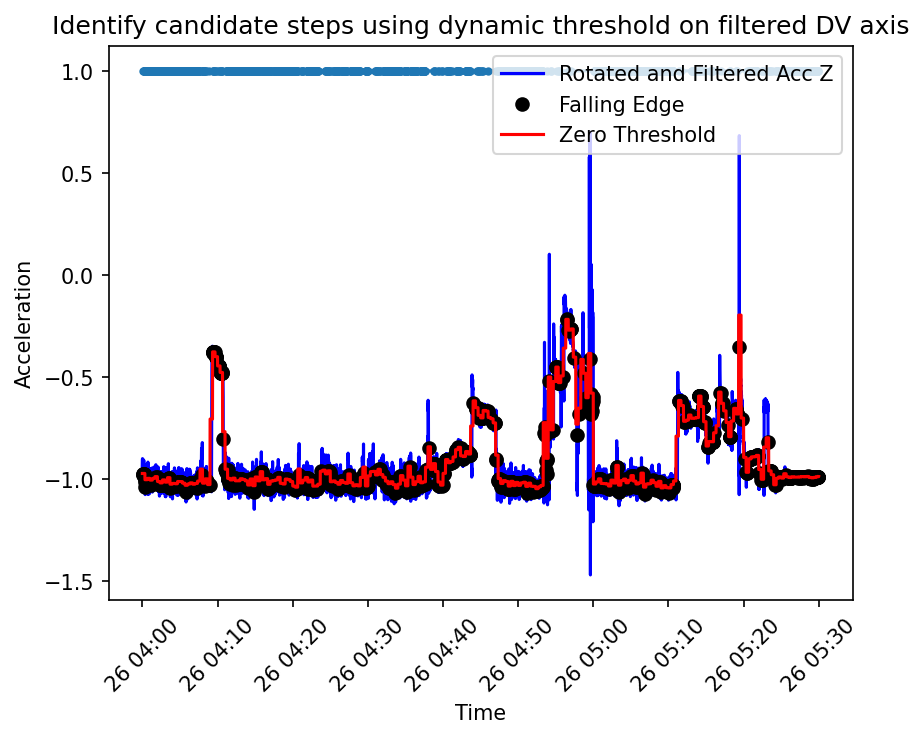

In [32]:
# PLOT ZERO THRESHOLD
FRAz = df['FRAz']
thresh_z = df['thresh_z']
dt = df['datetime']
dt_falling_edges = df[df['falling_edges'] == True]['datetime']
falling_edges = df[df['falling_edges'] == True]['FRAz']
dt_step_candidates = step_candidates['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, FRAz, linestyle='-', color='b', label='Rotated and Filtered Acc Z')
ax.plot(dt_falling_edges, falling_edges, marker = "o",linestyle='', color='black', label='Falling Edge')
ax.plot(dt, thresh_z,  linestyle='-', color='r', label='Zero Threshold')
ax.plot(dt_step_candidates,step_candidates['valid_step'],marker = ".")

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Identify candidate steps using dynamic threshold on filtered DV axis')
ax.legend()

# Show plot
plt.show()


## Estimate distance traveled

In [33]:
# Initialize distance column
step_candidates['distance_traveled'] = 0

# Calculate distance
for i in range(1,len(step_candidates)-1):

    # Identify the start and the end of the stride
    start_of_stride = step_candidates.iloc[i-1]
    t_start_of_stride = start_of_stride['datetime']
    
    end_of_stride = step_candidates.iloc[i+1]
    t_end_of_stride = end_of_stride['datetime']

    # Filter for accelerometery data between the start and end of the stride
    stride_data = df[(df['datetime'] >= t_start_of_stride) & (df['datetime'] <= t_end_of_stride)]
    df.loc[(df['datetime'] >= t_start_of_stride) & (df['datetime'] <= t_end_of_stride),'valid_step'] = 1

    # Get max and min acceleration
    max_acc = stride_data['RAz'].max()
    min_acc = stride_data['RAz'].min()

    # Estimate distance
    h = (max_acc - min_acc)**0.25

    step_candidates['distance_traveled'].iloc[i+1]=h

In [34]:
# Add error bounds assuming gps error is 0.5m
error = 0.5
gps_dist_lwr = np.maximum(0, np.array(euclidean_distance_step) - 2 * error)
gps_dist_upr = np.array(euclidean_distance_step) + 2 * error

In [35]:
# Calculate cumulative distance traveled
step_candidates['cum_dist'] = step_candidates['distance_traveled'].cumsum()
gps_cumsum = np.cumsum(euclidean_distance_step)
gps_cumsum_lwr = np.cumsum(gps_dist_lwr)
gps_cumsum_upr = np.cumsum(gps_dist_upr)

In [36]:
# Total distance traveled
step_candidates['distance_traveled'].sum()

1095.0637245866803

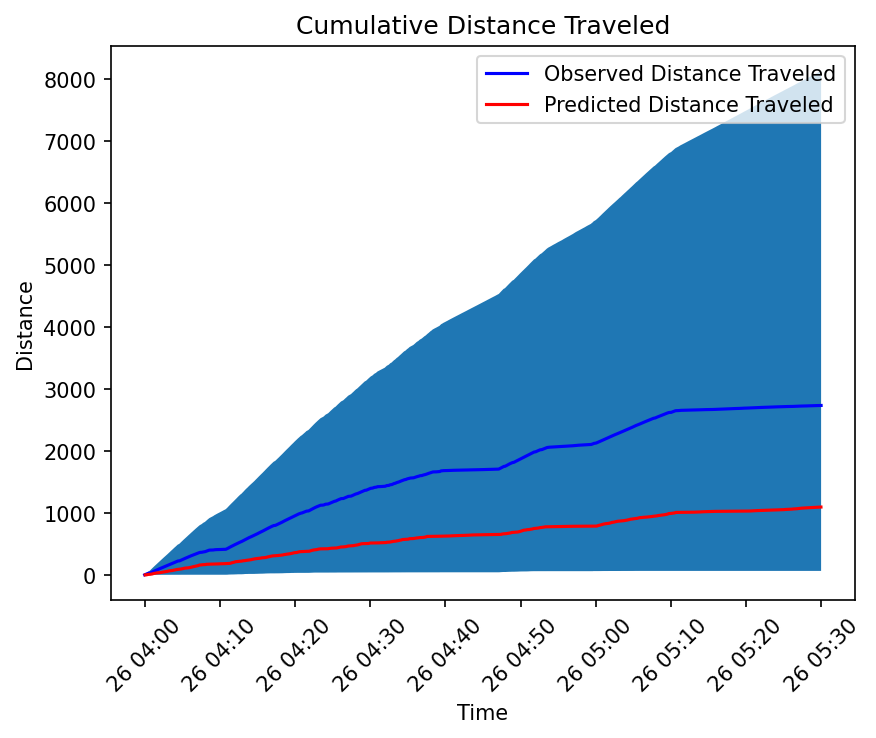

In [37]:
# Plot cumulative distance traveled
obs_dist = gps_cumsum
obs_dt = gps_pts['datetime'].iloc[:-1]
pred_dist = step_candidates['cum_dist']
pred_dt = step_candidates['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_dist, linestyle='-', color='b', label='Observed Distance Traveled')
ax.plot(pred_dt, pred_dist,linestyle='-', color='r', label='Predicted Distance Traveled')
plt.fill_between(obs_dt, gps_cumsum_lwr, gps_cumsum_upr)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Distance')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Cumulative Distance Traveled')
ax.legend()

# Show plot
plt.show()

## Estimate slope
  1) A low-pass butterworth filter can be applied to the pitch so that the resulting signal is a function of the tilt angle of the collar and the slope of the ground 
  2) If the filtered signal is equal to the sum of the slope angle and the collar angle, then slope = filtered signal - collar angle.
  3) Using a differential evolution optimizaion algorithm applied to a loss function, paraemters of a butterworth filter and collar angle  that minimized error between observed and predicted slopes can be obtained. 

In [38]:
#Placeholder function to simulate a black-box model's predictions
def model_predictions(params, data):
    # Define parameters
    cutoff_frequency, sampling_rate, collar_angle = params
    # Design the butterworth filter
    order = 4  # 4th order
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    data['filtered_pitch'] = filtfilt(b, a, data['pitch'])
    filtered_pitch = data.loc[data['filtered_pitch'].notnull(),'Slope1']
    # Predict slope
    slope =  filtered_pitch - collar_angle
    return slope

# def model_predictions(params, data):
#     # Define parameters
#     fs, f_low,f_high, collar_angle = params # sampling frequency, lower bound of passband, uppder bound of passband, collar angle
#     # Design the butterworth filter
#     order = 4  # 4th order
#     nyquist_frequency = 0.5 * fs
#     low = f_low/nyquist_frequency
#     high = f_high/nyquist_frequency
#     sos = butter(order, [low,high], btype='bandpass', output = 'sos')
#     data['filtered_pitch'] = sosfilt(sos,data['pitch'])
#     filtered_pitch = data.loc[data['filtered_pitch'].notnull(),'Slope1']
#     # Predict slope
#     slope =  filtered_pitch - collar_angle
#     return slope

# Define the cost function
def cost_function(params, data, actual):
    predictions = model_predictions(params, data)
    residuals = actual-abs(predictions)
    return np.sum((residuals)**2)

def objective(params):
    return cost_function(params,data,actual)

# Example data (replace with your actual data)
stride_data = df[df['valid_step']==1]
data = stride_data
actual = stride_data.loc[stride_data['Slope1'].notnull(),'Slope1']

# Differential Evolution (a type of genetic algorithm)
# bounds = [(100,10000),(0.001,0.1),(0.5,2),(-15*math.pi/180,-1*math.pi/180)]  #  parameter bounds
bounds = [(0.001,0.01),(1,5),(-0.21,-0.19)]
result = differential_evolution(objective, bounds)

#print("Optimal parameters:", result.x)

In [39]:
# # DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = result.x[0]  # Cutoff frequency in Hz
sampling_rate =  result.x[1] # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [40]:
# # Parameters
# order = 4  # 4th order
# fs = result.x[0] # Sampling rate in Hz (adjust as needed)
# nyquist_frequency = 0.5 * fs
# low = result.x[1]/nyquist_frequency
# high = result.x[2]/nyquist_frequency

# #low = f_low/nyquist_frequency
# #high = f_high/nyquist_frequency
# sos = butter(order, [low,high], btype='bandpass', output = 'sos')

In [41]:
# Create dataset where each row represents step endpoint
stride_data = df[df['valid_step']==1]
stride_data['filtered_pitch'] = filtfilt(b, a, stride_data['pitch'])
#stride_data['filtered_pitch'] = sosfilt(sos,stride_data['pitch'])
stride_data['collar_angle'] = result.x[2]
stride_data['slope_pred'] = stride_data['filtered_pitch'] - stride_data['collar_angle']

In [42]:
stride_data.head(30)

,rowID,valid_step,datetime,index,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,...,FRAx,FRAy,FRAz,magnitude,mag_mean,thresh_z,falling_edges,filtered_pitch,collar_angle,slope_pred
40,1.0,1.0,2019-02-26 04:00:04.000,201599,-0.047852,-0.203857,-0.863770,-0.088867,-0.167969,-0.200928,...,-0.341112,-0.046108,-0.981435,1.040047,NaN,-0.971737,True,-0.272785,-0.19,-0.082785
41,NaN,1.0,2019-02-26 04:00:04.075,201600,-0.143799,-0.239990,-0.803955,-0.092773,-0.173340,-0.191650,...,-0.360702,-0.050456,-1.001108,1.065302,NaN,-0.971737,False,-0.272811,-0.19,-0.082811
42,NaN,1.0,2019-02-26 04:00:04.175,201601,-0.323975,-0.551758,-1.535890,-0.093750,-0.175781,-0.188721,...,-0.375790,-0.045786,-1.014324,1.082667,NaN,-0.971737,False,-0.272837,-0.19,-0.082837
43,NaN,1.0,2019-02-26 04:00:04.275,201602,-0.431885,-0.431885,-1.175780,-0.106201,-0.164063,-0.195068,...,-0.378900,-0.032491,-1.013158,1.082178,NaN,-0.971737,False,-0.272864,-0.19,-0.082864
44,NaN,1.0,2019-02-26 04:00:04.375,201603,-0.167969,-0.191895,-0.995850,-0.103271,-0.167725,-0.192871,...,-0.368085,-0.012978,-0.997039,1.062893,NaN,-0.971737,False,-0.272890,-0.19,-0.082890
45,NaN,1.0,2019-02-26 04:00:04.475,201604,-0.119873,-0.191895,-0.863770,-0.085693,-0.174316,-0.193115,...,-0.347888,0.008624,-0.973333,1.033672,NaN,-0.971737,False,-0.272917,-0.19,-0.082917
46,NaN,1.0,2019-02-26 04:00:04.575,201605,-0.035889,-0.191895,-0.863770,-0.066894,-0.176270,-0.196289,...,-0.326364,0.027492,-0.952908,1.007623,NaN,-0.971737,False,-0.272943,-0.19,-0.082943
47,NaN,1.0,2019-02-26 04:00:04.675,201606,-0.107910,-0.179932,-0.767822,-0.064697,-0.171387,-0.202393,...,-0.310336,0.039388,-0.943774,0.994268,NaN,-0.971737,False,-0.272970,-0.19,-0.082970
48,NaN,1.0,2019-02-26 04:00:04.775,201607,-0.047852,-0.191895,-0.671875,-0.070312,-0.162842,-0.209717,...,-0.302052,0.041709,-0.946931,0.994813,NaN,-0.971737,False,-0.272996,-0.19,-0.082996
49,NaN,1.0,2019-02-26 04:00:04.875,201608,-0.383789,-0.191895,-1.500000,-0.079346,-0.160400,-0.208984,...,-0.299171,0.034093,-0.956878,1.003136,NaN,-0.971737,False,-0.273023,-0.19,-0.083023


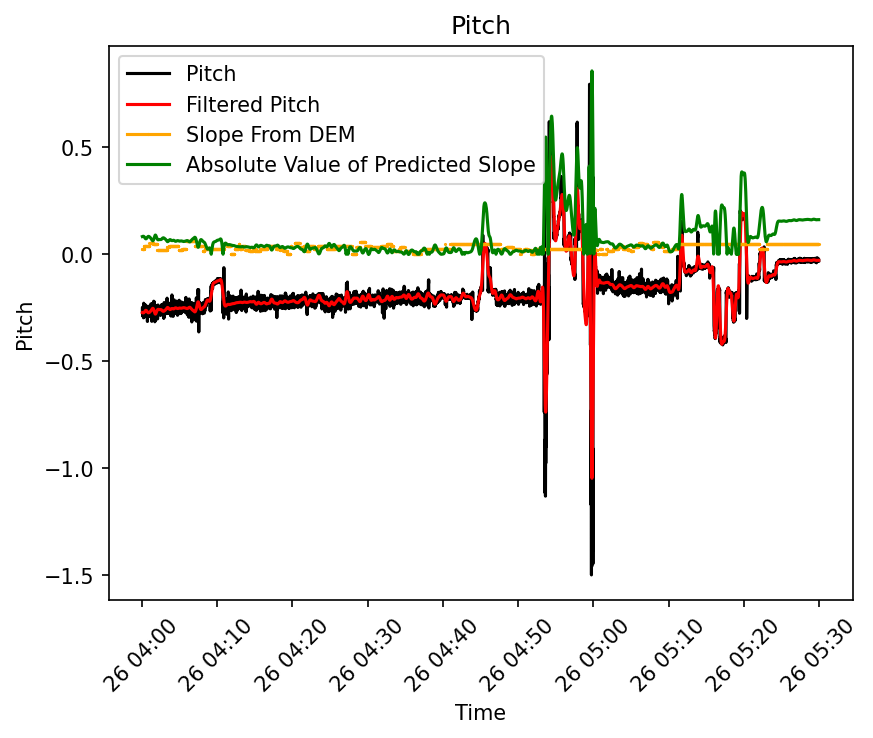

In [43]:
# PLOT PITCH OVER TIME

pitch = stride_data['pitch']
slope_guess = abs(stride_data['slope_pred'])
pitch_filt = stride_data['filtered_pitch'] 
dt = stride_data['datetime']
slope = stride_data['Slope1']*math.pi/180

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory

ax.plot(dt, pitch, linestyle='-', color='black', label='Pitch')
ax.plot(dt, pitch_filt,  linestyle='-', color='red', label='Filtered Pitch')

ax.plot(dt, slope,  marker = ".", color='orange', label='Slope From DEM', markersize = 1)
ax.plot(dt, slope_guess,  linestyle='-', color='g', label= 'Absolute Value of Predicted Slope')


# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Pitch')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Pitch')
ax.legend()

# Show plot
plt.show()


## Estimate Energy Expenditure
- Energy expenditure can be estimated using the same activation-relaxation cycling model (ARC model) employed by Berti et al. under the ENERSCAPE framework
- According to the ARC model, the energetic cost of transport is a function of distance traveled, slope of the ground, and body mass of the animal. Distance traveled and slope of the ground can be obtained using the algorithm above.

In [44]:
steps = pd.merge(step_candidates, stride_data,on = 'datetime', how='left')

In [45]:
# Set body mass
body_mass = 200

prev_slope = 0
def calc_energy(row):
    global body_mass
    global prev_slope
    dist = row['distance_traveled']
    #Ecot = 8*(body_mass**-0.34)+100*(1+math.sin(2*prev_slope-74))*(body_mass**-0.12) # J/m/kg
    #E = (Ecot*body_mass*dist)/4184 #kcal
    E = ((8*(body_mass**0.66))+(100*(body_mass**0.88)*(1+math.sin((2*prev_slope)-74))))*dist/4184
    prev_slope = row['slope_pred']*180/math.pi
    return E

steps['energy'] = steps.apply(calc_energy,axis=1)
steps['cum_energy'] = steps['energy'].cumsum()

In [46]:
prev_slope

9.266830260732634

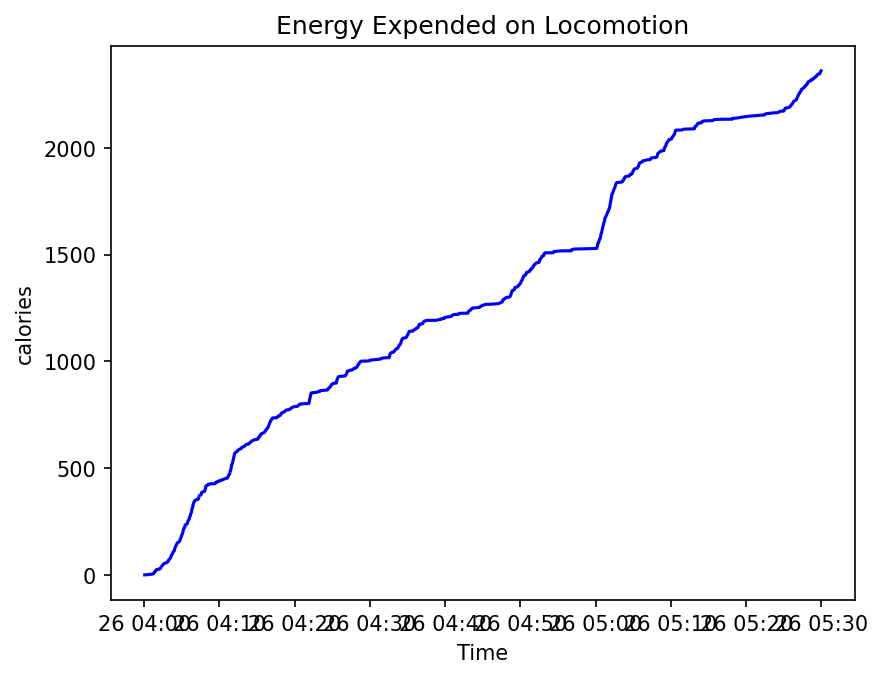

In [47]:
# PLOT CUMULATIVE ENERGY EXPENDITURE

energy = steps['cum_energy']
#energy = steps['distance_traveled']
dt = steps['datetime']

# Create a 3D plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the trajectory

ax1.plot(dt, energy, linestyle='-', color='blue', label='Cumulative Energy Expenditure')


# Setting labels
ax1.set_xlabel('Time')
ax1.set_ylabel('calories')

# Adding a title and legend
ax1.set_title('Energy Expended on Locomotion')
ax.legend()

# Show plot
plt.show()

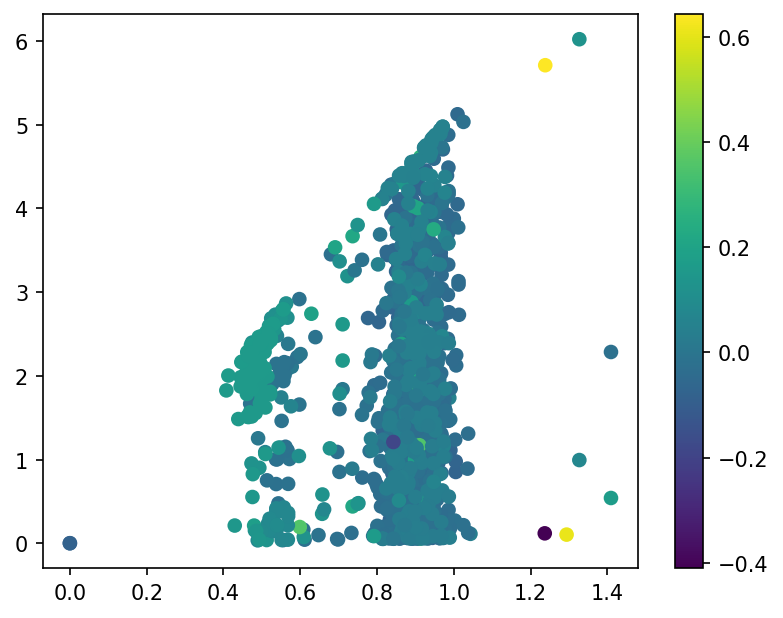

In [48]:
# plot distance vs energy
E = steps['energy']
dist = steps['distance_traveled']
slope = steps['slope_pred']

plt.scatter(dist,E, c = slope, cmap = "viridis")
plt.colorbar()  
plt.show()


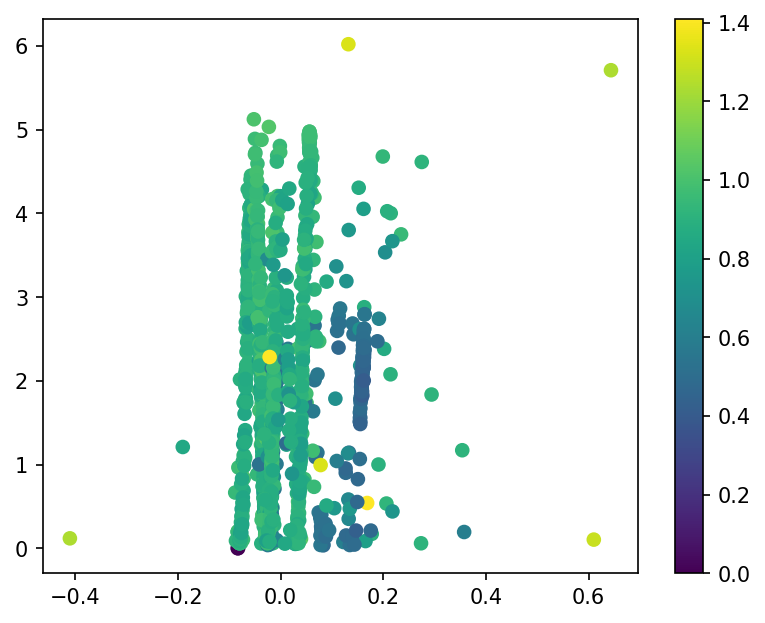

In [49]:
# plot slope vs energy
plt.scatter(slope,E, c = dist, cmap = "viridis")
plt.colorbar()
plt.show()
